In [61]:
# Loading libraries
import random                        # Library to generate random numbers
import skimage                       # Library for image manipulation
import numpy as np                   # Library for array manipulation
import urllib.request                # Library to download data
import matplotlib.pyplot as plt      # Library used for plotting
from skimage import io, measure               # Module from skimage
from skimage.io import imread        # Module from skimage to read images as numpy arrays
from skimage.filters import gaussian # Module working with a gaussian filter
import pathlib                              # Library to work with file paths
import os
%matplotlib inline

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians

from matplotlib import animation            # Module to plot animations

In [ ]:
#create an array 

#columns of array are: (0) tif number (1,2,3,or 4), (1) cell ID number, 
#(2) viability of cell (binary), (3) cell size, 
#(4) nucleus size, (5) protein concentration (AU), (6) count of mRNA in nucleus, 
#(7) count of mRNA in cytoplasm, (8) number of transcription sites, (9) intensity
#of transcription sites (vector), (10) time, (11) control or treatment, 
# (12) replicas

Load in tif files

In [93]:

figName = '/Users/knight/Git_Projects/UQbio2024_Team5/NoDrug/rep1_FOV1.tif'
# Loading figure to the notebook
images = imread(figName)
print('File is downloaded and accessible in: ... ./rep1_FOV1.tif ')


File is downloaded and accessible in: ... ./rep1_FOV1.tif 


Make a movie to view the tiff file. 

In [63]:
# Visualizing all frames (time points).
# blit=True re-draws only the parts that have changed
fig,axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
i=0
# Define inital frames
Red = images[i,:,:,0]
im1 = axes[0].imshow(Red,cmap='Reds_r')
Green = images[i,:,:,1]
im2 = axes[1].imshow(Green,cmap='Greens_r')
Blue = images[i,:,:,2]
im3 =  axes[2].imshow(Blue,cmap='Blues_r')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

def movieFrame(i):
  Red = images[i,:,:,0]
  Green = images[i,:,:,1]
  Blue = images[i,:,:,2]
  images_new = [Red,Green,Blue]
  image_handles = [im1,im2,im3]
  for k,image_n in enumerate(images_new):
    image_handles[k].set_array(images_new[k])
  return image_handles

plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=images.shape[0], interval=200, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

Overplaying channels 

In [65]:
# Here is a function to convert bit depth in an image
# Note - you will lose information if you convert to a lower bit depth
def convert_bit_depth(img, target_type_min, target_type_max, target_type):
    '''
    This function is intended to normalize img and change the image to the specified target_type
      img: numpy array
      target_type_min: int
      target_type_max: int
      target_type: str, options are: np.uint
    '''
    imin = img.min()
    imax = img.max()
    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [96]:
# Plotting a color image

# For many images, the color channels are stored in the last dimension. 
# For microscopy images, the colors are usually related to different fluorophores.
# For example, in this three color image, the first channel is red and corresponds
# to phosphorylated RNAP, the second is green and corresponds to phosphorylated RNAP,
# the third is blue, which corresponds to RNA.

# Make a 3x3 grid of images
# fig, ax = plt.subplots(1,4, figsize=(20, 7))


# # Plotting the color channels
# Red = images[:,:,:,0]
# ax[0].imshow(Red,cmap='Reds_r')
# ax[0].set(title='Red Channel (Ch 0) - RNAP')
# Green = images[:,:,:,1]
# ax[1].imshow(Green,cmap='Greens_r')
# ax[1].set(title='Green Channel (Ch 1) - RNAP-Phos')
# Blue = images[:,:,:,2]
# ax[2].imshow(Blue,cmap='Blues_r')
# ax[2].set(title='Blue Channel (Ch 2) - RNA')

# Now to create a merged color image. 
# We need to rescale the image to avoid saturation of the colors.
number_channels =3
rescaled_image = np.zeros_like(images)
# Rescaling image to avoid saturation
color_image = images[:,:,:,:].copy()
rescaled_image = np.zeros_like(color_image)
#for index_channels in range (number_channels):
#all channels
for index_channels in [0,2]:
  #red and blue
  normalized_image_temp = color_image[:,:, :, index_channels]
  # Pick a percentile value to avoid saturation
  max_val = np.percentile(color_image[:, :,:,index_channels], 97)
  # Set values above the percentile to the percentile value
  normalized_image_temp [normalized_image_temp > max_val] = max_val
  # Saved the thresholded image in the rescaled image
  rescaled_image[:, :,:,index_channels] = normalized_image_temp
# to show a color image in matplotlib, we need to convert it to uint8.
images = convert_bit_depth(rescaled_image, 0,255,target_type=np.uint8)

# # Now, let's plot the color image
# ax[3].imshow(img_int8_color)
# ax[3].set(title='Color image')
# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')
# ax[3].axis('off')
# plt.show()

# Visualizing all frames (time points).
# blit=True re-draws only the parts that have changed
fig,axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
i=0
# Define inital frames
red_blue = images[i,:,:]
im1 = axes[0].imshow(red_blue,cmap='Reds_r')
#Green = images[i,:,:,1]
#im2 = axes[1].imshow(Green,cmap='Greens_r')
# Blue = images[i,:,:,2]
# im3 =  axes[2].imshow(Blue,cmap='Blues_r')
# axes[0].axis('off')
# axes[1].axis('off')
# axes[2].axis('off')

def movieFrame(i):
  red_blue = images[i,:,:]
  #images_new = [Red,Green,Blue]
  images_new = [red_blue]
  #image_handles = [im1,im2,im3]
  image_handles = [im1]
  for k,image_n in enumerate(images_new):
    image_handles[k].set_array(images_new[k])
  return image_handles

plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=images.shape[0], interval=200, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [86]:
print(range(number_channels))

print([*range(number_channels)])
print(list(range(number_channels)))


range(0, 3)
[0, 1, 2]


TypeError: 'list' object is not callable

In [17]:
# Printing the shape of the image
print('Original image shape: ' , images.shape)  # [T,Y,X,C]

# Selecting a frame and a color channel
img = images[0,:,:,0]
print('Single image shape: ' , img.shape)  # [Y,X]

Original image shape:  (21, 650, 650, 3)
Single image shape:  (650, 650)


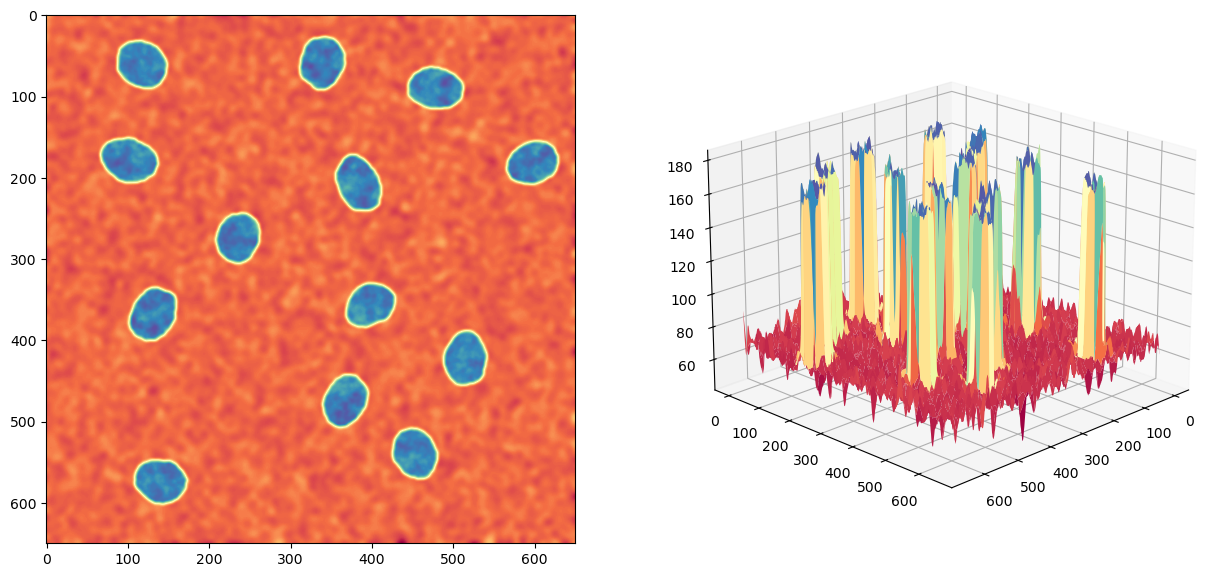

In [18]:
# Plotting the image as the 3d dimension figure.
space= np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(space,space)
fig = plt.figure(figsize=(15,7))

# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img,cmap='Spectral') # Reds_r

# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy , img,  rstride=20, cstride=20, shade=False, cmap='Spectral')
ax2.view_init(20, 45)
plt.show()

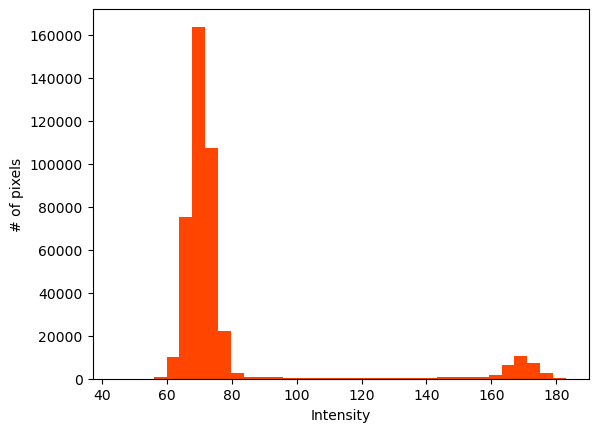

In [19]:
# Plotting the intensity distribution
f, ax = plt.subplots()
ax.hist(img.flatten(),color='orangered',bins=35)  # .ravel()
ax.set_xlabel('Intensity')
ax.set_ylabel('# of pixels')
plt.show()

Segmentation based on threshold selection:

In [20]:
# Thresholding the image
def viewer(threshold=50):
    test_image = img.copy()
    mask_image = np.zeros(img.shape)
    mask_image[test_image>threshold] = 255
    f,ax = plt.subplots()
    ax.imshow(mask_image, cmap='Greys')
    plt.show()

interactive_plot = interactive(viewer,threshold = widgets.IntSlider(min=0,max=2000,step=1,value=20,description='threshold'))       
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output])) 

Note that above, we  are choosing a threshold = 100 based on the graph above (between the two peaks).

Smoothing using a Gaussian filter. 

In [21]:
# Thresholding the image
def viewer(threshold=50, sigma=5):
    mask_image = np.zeros(img.shape)
    mask_image[img>threshold] = 255
    new_mask = gaussian(mask_image, sigma=sigma)
    f,ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(mask_image, cmap='Spectral')
    ax[1].imshow(new_mask, cmap='Spectral')
    plt.show()
    return new_mask

interactive_plot = interactive(viewer, \
            threshold = widgets.IntSlider(min=0,max=1000,step=1,value=200,description='threshold'),\
            sigma = widgets.IntSlider(min=0,max=10,step=1,value=3,description='sigma'))       

controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))    

# select 100 (threshold) and 3 (sigma- variance)

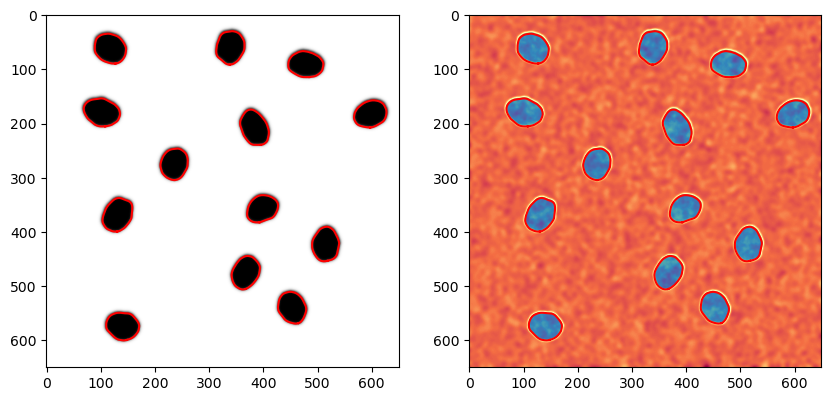

In [22]:
# Plotting all contours detected in the filtered image
new_mask = interactive_plot.result
#new_mask = img.copy()
f,ax = plt.subplots(1,2, figsize=(10,5))
contours = measure.find_contours(new_mask, level=200 ) # level is half of 255 (ish). What happens if we change it?
contours_connected = np.vstack((contours))
# downsample the contours
contours_connected = contours_connected[::20] 
ax[0].imshow(new_mask, cmap='Greys')
ax[1].imshow(images[0,:,:,0], cmap='Spectral')
for contour in contours:
  ax[0].plot(contour[:,1],contour[:,0],color='r')  
  ax[1].plot(contour[:,1],contour[:,0],color='r')

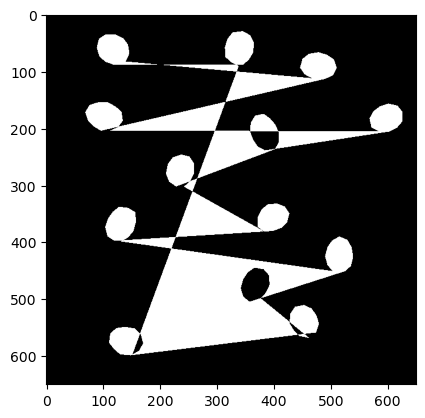

min value in mask:  0
max value in mask:  1


In [23]:
# # make a new mask from the contours array
# watershed_starting_mask = np.zeros(img.shape).astype(int)                    # Pre-allocating an array with zeros. Notice the datatype.
# rr, cc = polygon(contours_connected[:,0], contours_connected[:,1])           # Returns the coordinates inside the contour
# watershed_starting_mask[rr,cc] = 1                                           # Replacing all values inside the contour with ones.

# # Plotting the mask
# f,ax = plt.subplots()
# ax.imshow(watershed_starting_mask, cmap='Greys_r')
# plt.show()

# # Printing the minimum and maximum values in the image
# print('min value in mask: ', np.min(watershed_starting_mask) )
# print('max value in mask: ', np.max(watershed_starting_mask) )

Goal: To count the number of cells 
-segmenting a complete cell using library cellpose 

In [24]:
from cellpose import plot, models

separate the three channels (green, red, and blue)

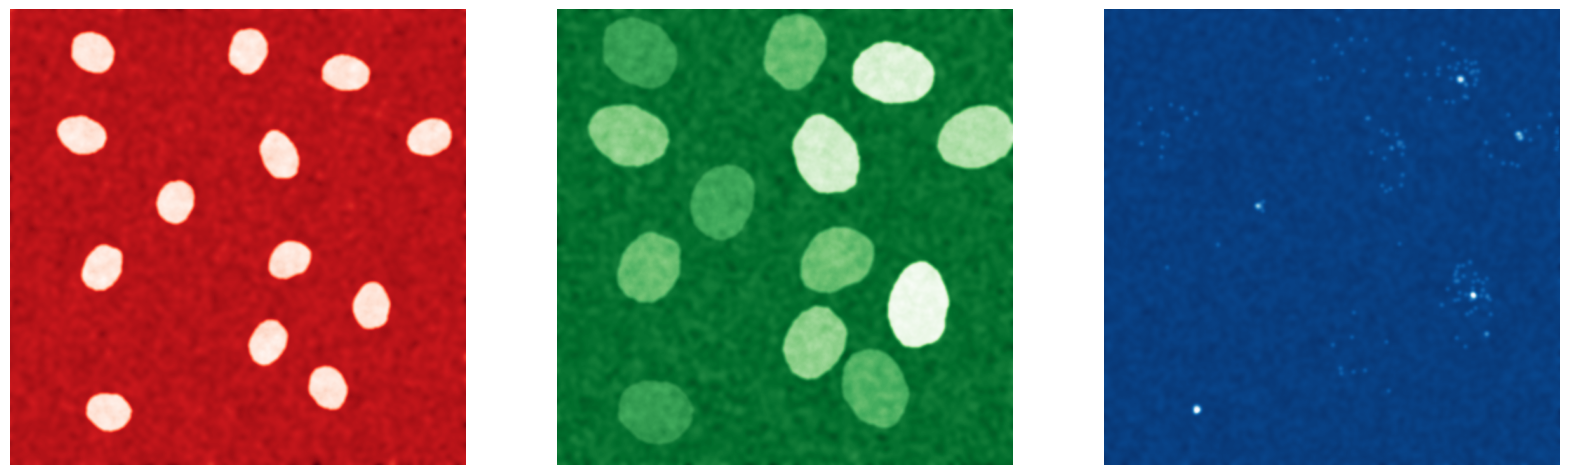

In [25]:
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,3, figsize=(20, 7))
ax[0].imshow(images[0,:,:,0],cmap='Reds_r')
ax[1].imshow(images[0,:,:,1],cmap='Greens_r')
ax[2].imshow(images[0,:,:,2],cmap='Blues_r')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

In [26]:
img = images[0,:,:,0]

In [27]:
# RUN CELLPOSE
model = models.Cellpose(model_type='cyto') # model_type='cyto' or model_type='nuclei'
masks  = model.eval(img, diameter=200)[0]

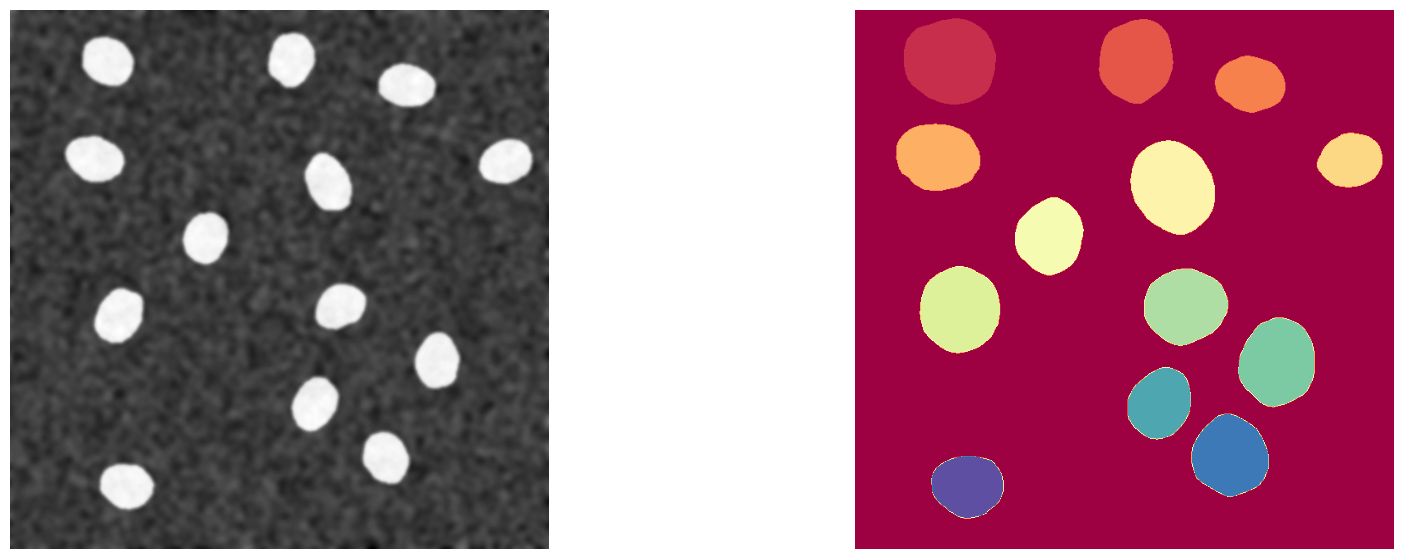

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [28]:
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,2, figsize=(20, 7))
ax[0].imshow(img,cmap='Greys_r')
ax[1].imshow(masks,cmap='Spectral')
ax[0].axis('off')
ax[1].axis('off')
plt.show()
print('Values in mask: ', np.unique (masks))

In [30]:
num_cells= len(np.unique(masks))-1
print(num_cells)

13


Note we have 13 unique cells. 

Segmenting nuclei and cytosol

In [33]:
images_FISH = images

# The image has the following dimensions [Z,Y,X,C]
print('The image has the following dimensions [Z,Y,X,C]: ' ,images_FISH.shape)

# For segmentation, we will select the central  slice.
image_to_segment= images_FISH[10,:,:,:]

The image has the following dimensions [Z,Y,X,C]:  (21, 650, 650, 3)


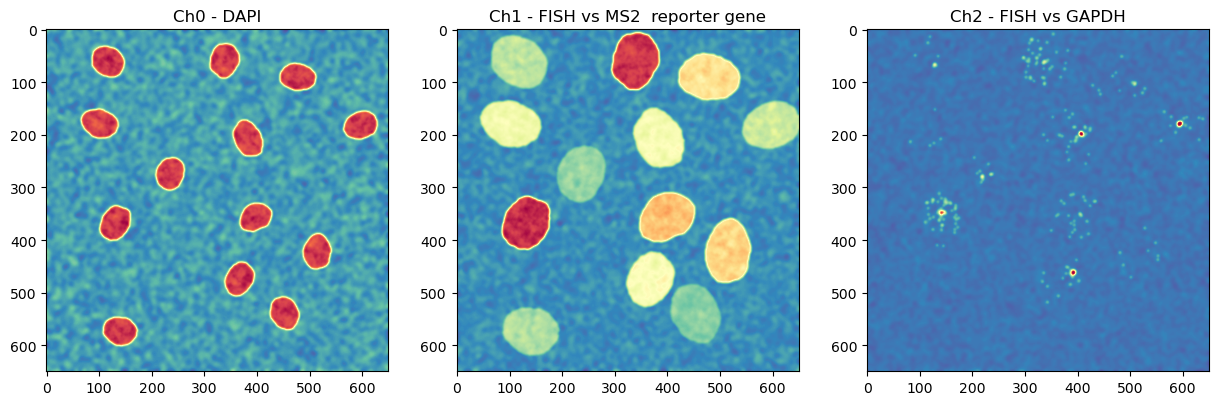

In [34]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))
zSlice = 10
ax[0].imshow(images_FISH[zSlice,:,:,0],cmap='Spectral_r')
ax[0].set(title='Ch0 - DAPI')
ax[1].imshow(images_FISH[zSlice,:,:,1],cmap='Spectral_r')
ax[1].set(title= 'Ch1 - FISH vs MS2  reporter gene' )
ax[2].imshow(images_FISH[zSlice,:,:,2],cmap='Spectral_r')
ax[2].set(title= 'Ch2 - FISH vs GAPDH' )
plt.show()

Segmenting the nuclei

(650, 650, 2)
number of detected cells:  13


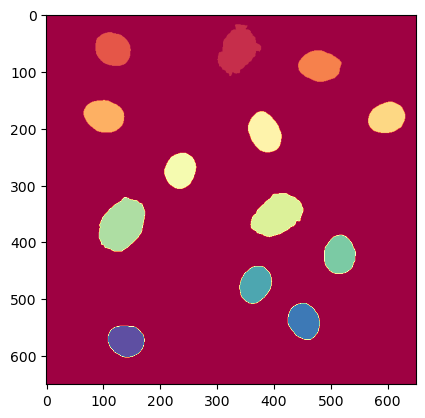

In [35]:
# Segmenting the nuclei
img_nuc = images_FISH[zSlice,:,:,0:2]
print(img_nuc.shape)
use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
model = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
print('number of detected cells: ', np.max(masks_nuc))
plt.imshow(masks_nuc,cmap='Spectral')
plt.show()

Segmenting the cytosol

(650, 650, 3)


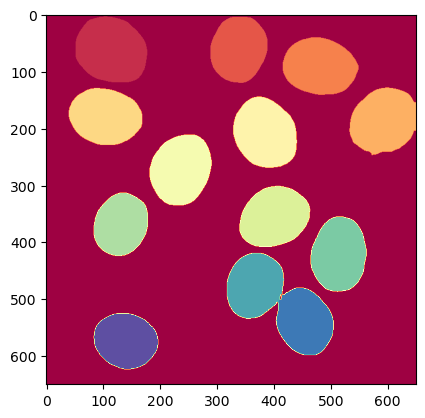

In [36]:
# Segmenting the cytosol
img_cyto = images_FISH[zSlice,:,:,0:3]
print(img_cyto.shape)
use_GPU = False
model = models.Cellpose(gpu=use_GPU, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2])
plt.imshow(masks_cyto,cmap='Spectral')
plt.show()

To look at just the 8th cell (of 13):

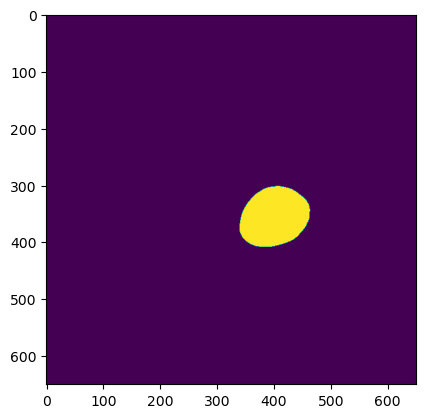

In [37]:
plt.imshow(masks_cyto==8)
plt.show()

Calculating the area of each of cell in the image 

In [43]:
# calculate the area of each cell
cell_areas = []
for i in range(1, np.max(masks_cyto)+1):
    cell_areas.append(np.sum(masks_cyto==i))
print('The area of all ' + str(num_cells) +' cells in pixels is:', cell_areas[:num_cells])







The area of all 13 cells in pixels is: [11671, 9176, 10349, 10717, 10045, 10822, 10477, 10185, 8228, 10080, 9035, 9085, 8546]


In [44]:
# Associating each nucleus with its corresponding cytosol
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

print(nucleus_indices)

[ 0.  2.  1.  3.  5.  4.  6.  7.  8.  9. 10. 11. 12. 13.]


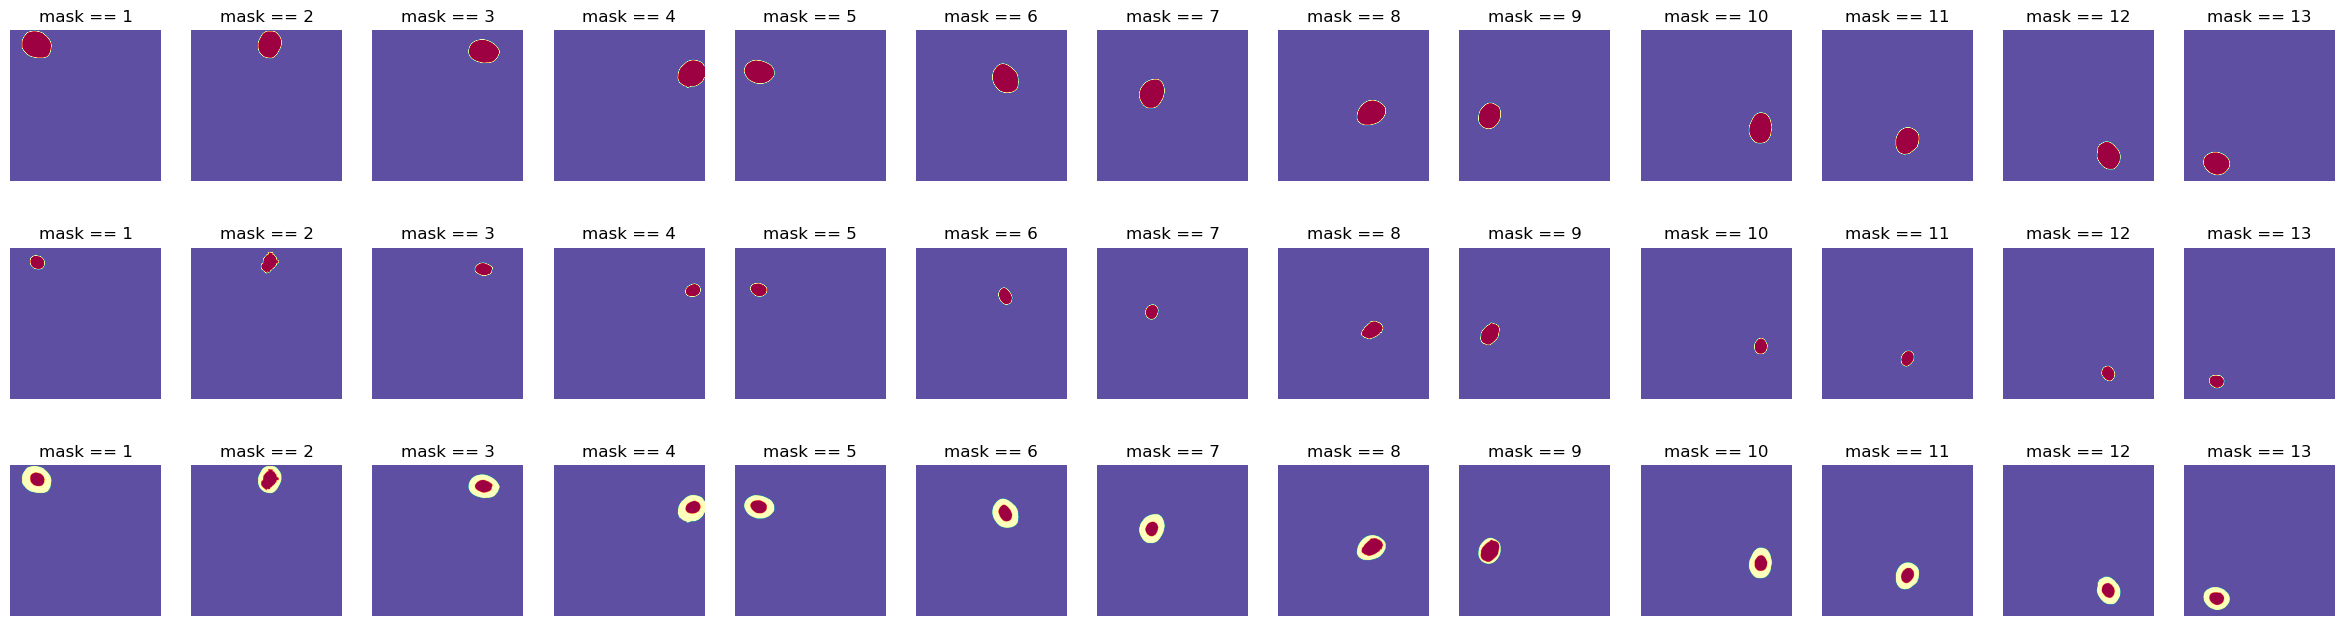

In [47]:
# Show the cytoplasms and corresponding nuclei
number_detected_cells = np.max(masks_cyto)

fig, ax = plt.subplots(3,number_detected_cells, figsize=(30, 8))
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  ax[0,i-1].imshow(selected_cyto_mask,cmap='Spectral_r')
  ax[0,i-1].set(title='mask == ' + str(i) )
  ax[0,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  ax[1,i-1].imshow(selected_nuc_mask,cmap='Spectral_r')
  ax[1,i-1].set(title='mask == ' + str(i) )
  ax[1,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  combined = selected_nuc_mask.astype(int) + selected_cyto_mask.astype(int)
  ax[2,i-1].imshow(combined,cmap='Spectral_r')
  ax[2,i-1].set(title='mask == ' + str(i) )
  ax[2,i-1].axis('off')
plt.show()

First row is the entire cell for cell i. 
Second row is the nucleus of the cell i. 
Thrid row is the cytoplasm of the cell i.
Each column corresponds to each unique cell i. 

First let's look at the nucleus of one particular cell. 

/var/folders/4h/hh7w04rj0d13bnb6p5q8tvcm0000gn/T/ipykernel_99336/145743347.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


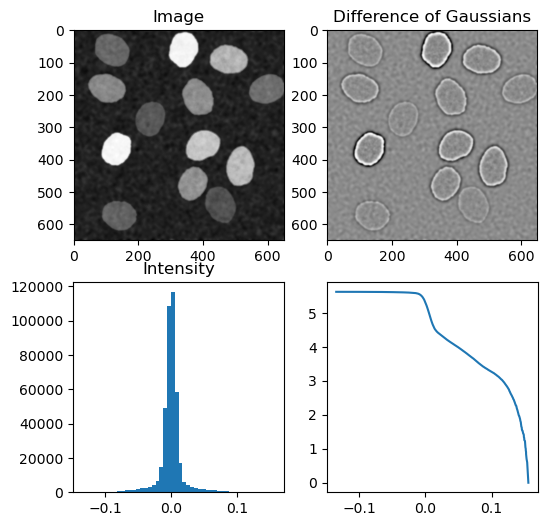

intensity range:  -0.13460870492381555 0.15656919423715987


In [48]:
# Selecting the color channel with RNA spots
zSlice = 10 #time frame
iChannel = 1 #which channel 
img_spots = images_FISH[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [49]:
threshold = 0.05

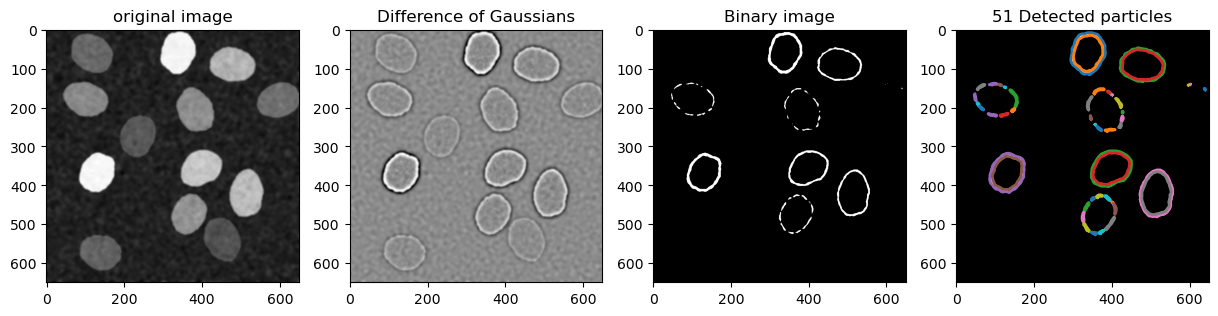

In [50]:
# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

This plot shows the number of detected mRNA particles in the particular nucleus at a particular time frame. 

In [52]:
import pandas as pd

In [57]:
# Counting the detected particles in each cell

list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        #greater than 0 because the background is 0
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe

print(list_cytosol_particles)
print(sum(list_cytosol_particles))
print(list_nuclear_particles)
print(sum(list_nuclear_particles))


[ 0.  2.  2.  3. 11. 14.  0.  2.  2.  2. 13.  0.  0.]
51.0
[0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 0. 0. 0.]
10.0


Comment: We believe the list_cytoplasm_particles= list_cytosol_particles- list_nuclear_particles

In [59]:
list_cytoplasm_particles= list_cytosol_particles- list_nuclear_particles
sum(list_cytoplasm_particles)

41.0

Total of 51 particles (mRNA) is this nucleus and cytoplasm (ie entire cell) at this time frame. 

Transcription site detection:

In [ ]:
print(spot_contours[1])

Column 0:tif number (1,2,3,or 4)  


In [ ]:
#assign tif number to column 0 in the df 

Column 1: cell ID number

In [ ]:
#need to locate each cell at each time, give an ID number for each unique cell, start with 1 and go up by +1 

Column 2: viability of cell (binary)


In [ ]:
#use intensity (or maybe presense of nucleus) in order to determine if cell is viabile or not (0 not viable, 1 viable)
#does cell have a nucleus, transcrption site? 

Column 3: cell size

In [ ]:
#identify location of each cell, use techniques from lesson 2 

Column 4: nucleus size


In [ ]:
# identify nucleus location on blue channel and use techiques from lesson 2 

Column 5: protein concentration (AU) (number of proteins per area)


In [ ]:
#identiy which channel the protein is located in by looking at characteristics such as shape 
#then quantify the number of proteins in the frame
#know area of frame using size of x and y 
#divide the number of proteins by the size of the frame to get concentration

Column 6: count of mRNA in nucleus

In [ ]:
#identify which channel mRNA is located in - look at nucleus
#create a function which takes in a region of the cell (ie nucleus) which counts the number of mRNA 

Column 7: count of mRNA in cytoplasm

In [ ]:
#identify which channel mRNA is located in - look at cytoplasm 
#create a function which takes in a region of the cell (ie cytoplasm) which counts the number of mRNA 

Column 8: number of transcription sites (in nucleus)

In [ ]:
#write a function which takes in a region of the cell (nucleus in this case) to count the number of transcription sites
#store this in the df 

Column 9: intensity of transcription sites (vector)

In [ ]:
#determine threshold for intensity of transcription sites in order to say if there is a transcription site or not 

Column 10: time

In [ ]:
#use the time frame from tif file and assign to column 10 of the df 

Column 11: control or treatment (0 is control, 1, 2, 3 for drug treatments )

In [ ]:
#asign value (based on folder) 

Column 12: replica 

In [ ]:
#assign either 1 or 2 to the column (based on control treatment) 